Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [1]:
from palmerpenguins import load_penguins
import pandas as pd

penguins = load_penguins()
'''
# Get dummies for all categorical variables
penguins_dummies1 = pd.get_dummies(penguins, columns=['species'], prefix=['species'], prefix_sep='_', dtype= int)
penguins_dummies2 = pd.get_dummies(penguins_dummies1, columns=['island'], prefix=['island'], prefix_sep='_', dtype= int)
penguins_dummies3 = pd.get_dummies(penguins_dummies2, columns=['sex'], prefix=['sex'], prefix_sep='_', dtype= int)
penguins_dummies4 = pd.get_dummies(penguins_dummies3, columns=['year'], prefix=['year'], prefix_sep='_', dtype= int)
'''

penguins = penguins.dropna()

Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [5]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

# Set up target and predictor variables
y = penguins["bill_depth_mm"]
X = penguins.drop(columns= ["bill_depth_mm"])

# create ct to dummify and standardize
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

# Define pipelines for each model
pipeline_ols = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', LinearRegression())
])
pipeline_KNN3 = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', KNeighborsRegressor(n_neighbors=3))
])
kNN7_pipeline = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', KNeighborsRegressor(n_neighbors=7))
])
pipeline_tree = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

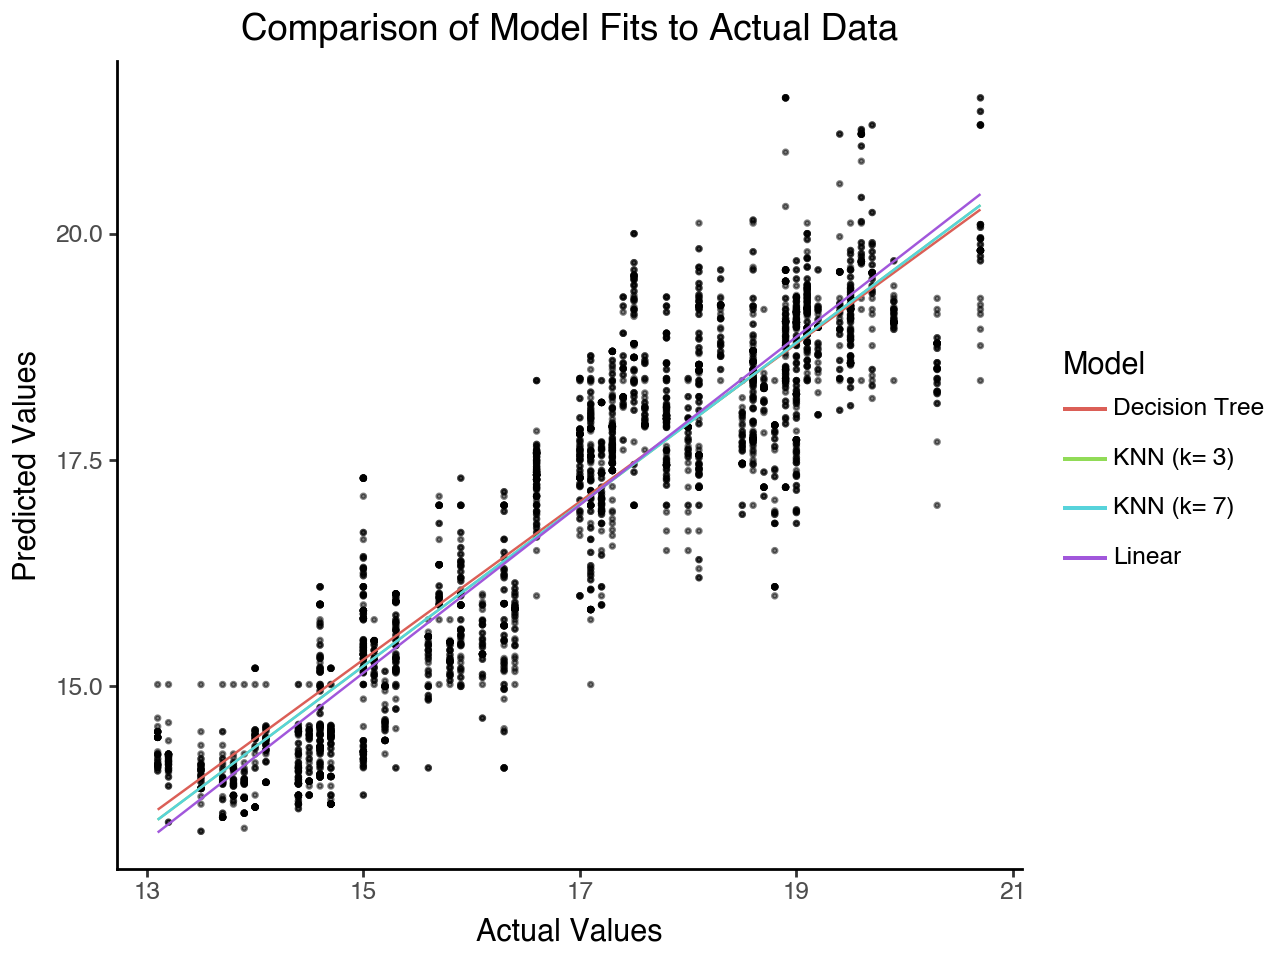

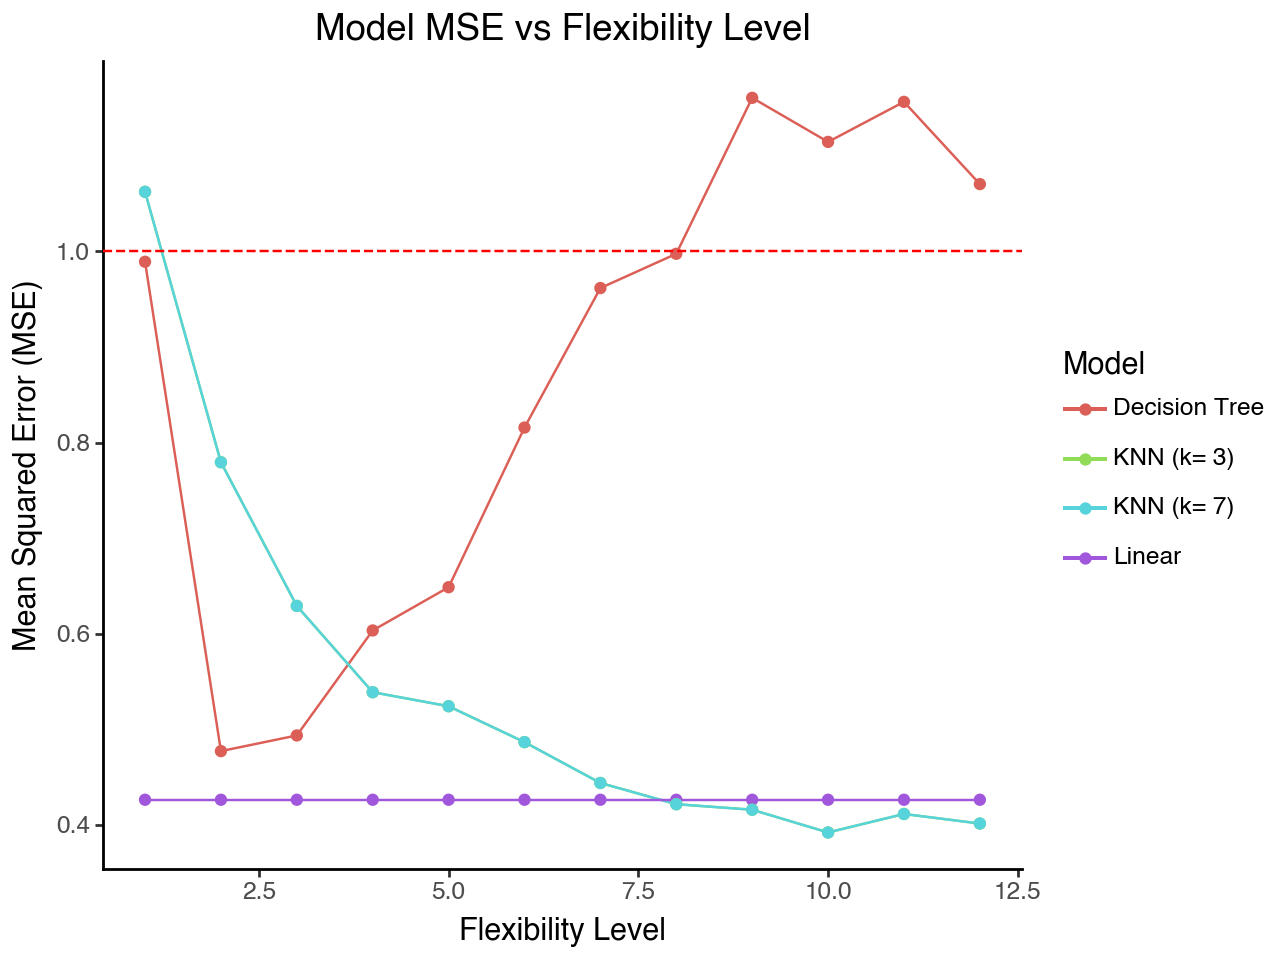

In [6]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from plotnine import ggplot, aes, geom_point, geom_line, labs, theme_classic, geom_smooth, geom_hline, scale_y_continuous

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Prepare the data for plotting
dataframes = []
models = [pipeline_ols, pipeline_KNN3, kNN7_pipeline, pipeline_tree]
model_names = ['Linear', 'KNN (k= 3)', 'KNN (k= 7)', 'Decision Tree']

# Create lists to store plotting data
fit_data = []
mse_data = []
flexibilities = [1,2,3,4,5,6,7,8,9,10,11,12]

mse_data = []
# Iterate over each model
for i, model in enumerate(models):
    for j, flexibility in enumerate(flexibilities):  # Iterate over flexibility levels
        
        # Apply flexibility to models that require it (e.g., KNN, Decision Tree)
        if model == pipeline_KNN3 or model == kNN7_pipeline:  # KNN models
            model.set_params(regressor__n_neighbors=flexibility)  # Example: changing the number of neighbors with flexibility
        
        elif model == pipeline_tree:  # Decision Tree model
            model.set_params(regressor__max_depth=flexibility)  # Example: changing the maximum depth of the tree
        
        # Fit the model with current flexibility level
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        fit_data.append(pd.DataFrame({'Actual': y_test,'Predicted': y_pred,'Model': model_names[i]}))

        # Calculate MSE for the test set
        mse = sk.metrics.mean_squared_error(y_test, y_pred)
        
        # Store the result
        mse_data.append({'Model': model_names[i], 'Flexibility': flexibility, 'MSE': mse})

pred_df = pd.concat(fit_data, ignore_index=True)
mse_df = pd.DataFrame(mse_data)

# Make plot for flexibility graph
flex_plot = (ggplot(mse_df, aes(x = "Flexibility", y = "MSE", color = "Model")) +
  geom_line() + # Line plot to connect points
  geom_point() + # Points for each flexibility level
  geom_hline(yintercept = 1, linetype = "dashed", color = "red") +
  labs(title = "Model MSE vs Flexibility Level",
       x = "Flexibility Level",
       y = "Mean Squared Error (MSE)",
       color = "Model") +
  theme_classic())

# Make plot for best fit graph
fit_plot = (
    ggplot(pred_df, aes(x='Actual', y='Predicted', color='Model')) +
    geom_point(aes(x='Actual', y='Predicted'), color='black', alpha=0.5, size=.5) +
    geom_smooth(aes(color='Model'), method='lm', se=False, linetype="solid", size = .5) +
    labs(title="Comparison of Model Fits to Actual Data",
         x="Actual Values",
         y="Predicted Values") +
    theme_classic()
)


fit_plot.show()
flex_plot.show()
